In [2]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from torchvision import transforms


In [4]:
# Load the dataset from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/Data/digit/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Data/digit/test.csv')

# Split training data into features and labels
X = train_data.iloc[:, 1:].values.astype('float32')  # All pixel values
y = train_data.iloc[:, 0].values.astype('int64')     # Labels (digits)

# Normalize the data (pixel values range from 0 to 255)
X = X / 255.0

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [5]:
# Exploratory Data Analysis (EDA)

# step 01 - Understanding the Dataset Structure
# Check the dataset's dimensions
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Training data shape: (42000, 785)
Test data shape: (28000, 784)


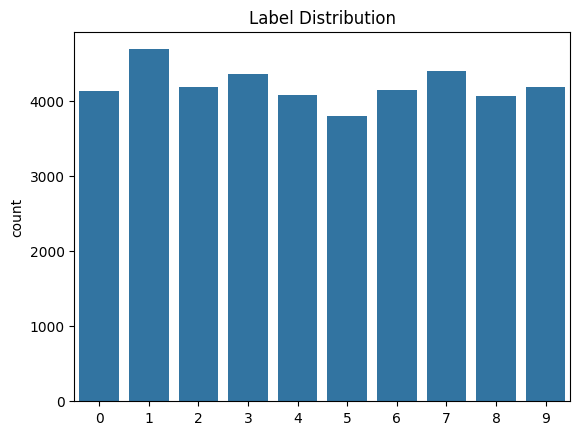

In [6]:
# Label Distribution: to check the dataset is balanced or imbalanced.
sns.countplot(x=y)
plt.title("Label Distribution")
plt.show()

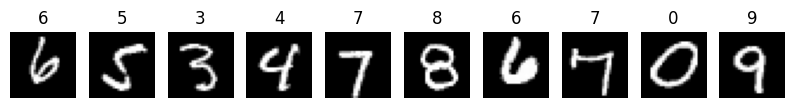

In [7]:
# Visualize Sample Images
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(y_train[i])
    axes[i].axis('off')
plt.show()

In [8]:
#Create a custom dataset class
class MNISTDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]


In [9]:
# Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create dataloaders for training and validation.
batch_size = 64

train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# Define the CNN model.
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
#Initialize the model, loss function and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
# Train the model
# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

# Define the training loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape to [batch_size, 1, 28, 28]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i + 1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

    # Return average loss and accuracy for the epoch
    return running_loss / len(train_loader), running_acc / len(train_loader)

# Track training loss and accuracy
train_losses = []
train_accuracies = []


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    avg_loss, avg_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

Epoch 1, Batch 200, Loss: 0.0174, Accuracy: 0.9962
Epoch 1, Batch 400, Loss: 0.0129, Accuracy: 0.9970
Epoch 2, Batch 200, Loss: 0.0135, Accuracy: 0.9973
Epoch 2, Batch 400, Loss: 0.0082, Accuracy: 0.9976
Epoch 3, Batch 200, Loss: 0.0083, Accuracy: 0.9982
Epoch 3, Batch 400, Loss: 0.0027, Accuracy: 0.9993
Epoch 4, Batch 200, Loss: 0.0136, Accuracy: 0.9970
Epoch 4, Batch 400, Loss: 0.0074, Accuracy: 0.9977
Epoch 5, Batch 200, Loss: 0.0061, Accuracy: 0.9981
Epoch 5, Batch 400, Loss: 0.0071, Accuracy: 0.9979
Epoch 6, Batch 200, Loss: 0.0017, Accuracy: 0.9996
Epoch 6, Batch 400, Loss: 0.0007, Accuracy: 0.9997
Epoch 7, Batch 200, Loss: 0.0034, Accuracy: 0.9989
Epoch 7, Batch 400, Loss: 0.0077, Accuracy: 0.9977
Epoch 8, Batch 200, Loss: 0.0103, Accuracy: 0.9979
Epoch 8, Batch 400, Loss: 0.0100, Accuracy: 0.9977
Epoch 9, Batch 200, Loss: 0.0045, Accuracy: 0.9991
Epoch 9, Batch 400, Loss: 0.0032, Accuracy: 0.9993
Epoch 10, Batch 200, Loss: 0.0071, Accuracy: 0.9988
Epoch 10, Batch 400, Loss: 0.0

In [13]:
# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape inputs to [batch_size, channels, height, width]
            inputs = inputs.view(-1, 1, 28, 28)  # MNIST images have a single channel (grayscale)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item()

            # Accumulate accuracy
            test_acc += accuracy(outputs, labels)

            # Store predictions and actual labels for further analysis if needed
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}')

    return all_preds, all_labels

# Test the model
all_preds, all_labels = test(model, device, test_loader, criterion)

Test Loss: 0.0382, Test Accuracy: 0.9879


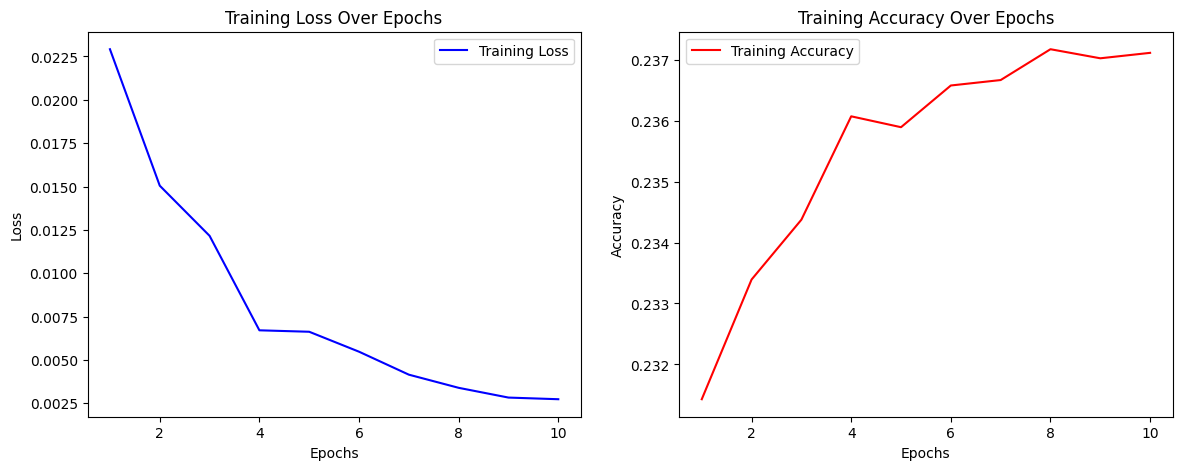

In [14]:
# Visualize Training Progress
#train_losses and train_accuracies that store loss and accuracy after each epoch
def plot_training_progress(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot the training loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# After training, visualize the progress
plot_training_progress(train_losses, train_accuracies)

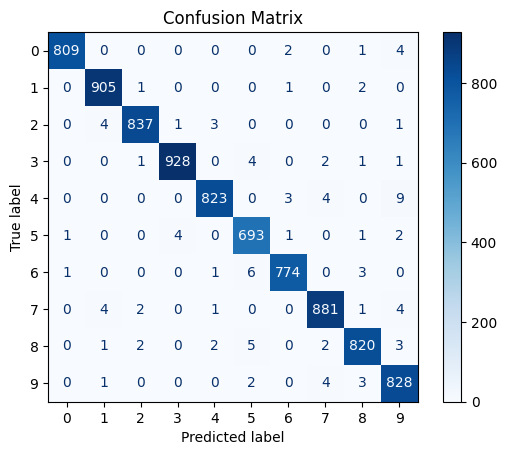

In [15]:
# Get confusion metrics to see module performing
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

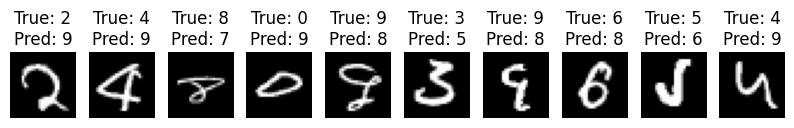

In [16]:
# display some examples where the model made incorrect predictions.
def visualize_incorrect_predictions(all_labels, all_preds, dataset, num_samples=10):
    incorrect_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]

    # Set up the plot
    plt.figure(figsize=(10, 2))

    # Randomly select incorrect predictions to visualize
    selected_indices = np.random.choice(incorrect_indices, num_samples, replace=False)

    for i, idx in enumerate(selected_indices):
        image, label = dataset[idx]
        image = image.view(28, 28).numpy()  # Reshape the image for visualization
        pred_label = all_preds[idx]

        # Plot the image with true and predicted labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {label}\nPred: {pred_label}')
        plt.axis('off')

    plt.show()

# Example usage (assuming `all_labels`, `all_preds`, and `test_dataset` are defined)
visualize_incorrect_predictions(all_labels, all_preds, test_dataset, num_samples=10)

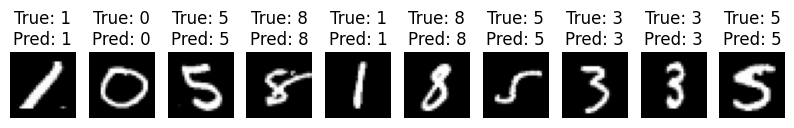

In [17]:
# display some examples where the model made correct predictions.
def visualize_correct_predictions(all_labels, all_preds, dataset, num_samples=10):
    correct_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true == pred]

    # Set up the plot
    plt.figure(figsize=(10, 2))

    # Randomly select correct predictions to visualize
    selected_indices = np.random.choice(correct_indices, num_samples, replace=True)

    for i, idx in enumerate(selected_indices):
        image, label = dataset[idx]
        image = image.view(28, 28).numpy()  # Reshape the image for visualization
        pred_label = all_preds[idx]

        # Plot the image with true and predicted labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'True: {label}\nPred: {pred_label}')
        plt.axis('off')

    plt.show()

# Example usage (assuming `all_labels`, `all_preds`, and `test_dataset` are defined)
visualize_correct_predictions(all_labels, all_preds, test_dataset, num_samples=10)

In [18]:
# re-defining the model
# Define the CNN model with additional convolutional and fully connected layers
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # New convolutional layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # New convolutional layer

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = None
        self.fc2 = nn.Linear(512, 256)       # New fully connected layer
        self.fc3 = nn.Linear(256, 10)        ## Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))   # Forward pass through the new convolutional layer
        x = self.pool(F.relu(self.conv4(x)))   # Forward pass through the new convolutional layer

        # Calculate the input size for the fully connected layer dynamically
        if self.fc1 is None:
            # Flatten the tensor and calculate the correct input size for fc1
            num_features = x.size(1) * x.size(2) * x.size(3)
            self.fc1 = nn.Linear(num_features, 512).to(x.device)

        # Adjust the view according to the actual output size
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))                # Forward pass through the new fully connected layer
        x = self.fc3(x)                        # Output layer

        return x

# Create an instance of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
print(model)

dummy_input = torch.randn(1, 1, 28, 28).to(device)  # A single 28x28 input image
output = model(dummy_input)
print(output.shape)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([1, 10])


In [19]:
#Initialize the model, loss function and optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
# Train the model
# Define a function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

# Define the training loop
def train(model, device, train_loader, criterion, optimizer, epoch):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape to [batch_size, 1, 28, 28]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i + 1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

    # Return average loss and accuracy for the epoch
    return running_loss / len(train_loader), running_acc / len(train_loader)

# Track training loss and accuracy
train_losses = []
train_accuracies = []


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    avg_loss, avg_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

Epoch 1, Batch 200, Loss: 0.6792, Accuracy: 0.7675
Epoch 1, Batch 400, Loss: 0.1310, Accuracy: 0.9598
Epoch 2, Batch 200, Loss: 0.0741, Accuracy: 0.9765
Epoch 2, Batch 400, Loss: 0.0694, Accuracy: 0.9788
Epoch 3, Batch 200, Loss: 0.0529, Accuracy: 0.9848
Epoch 3, Batch 400, Loss: 0.0484, Accuracy: 0.9840
Epoch 4, Batch 200, Loss: 0.0375, Accuracy: 0.9891
Epoch 4, Batch 400, Loss: 0.0358, Accuracy: 0.9874
Epoch 5, Batch 200, Loss: 0.0277, Accuracy: 0.9913
Epoch 5, Batch 400, Loss: 0.0296, Accuracy: 0.9909
Epoch 6, Batch 200, Loss: 0.0191, Accuracy: 0.9941
Epoch 6, Batch 400, Loss: 0.0271, Accuracy: 0.9920
Epoch 7, Batch 200, Loss: 0.0134, Accuracy: 0.9956
Epoch 7, Batch 400, Loss: 0.0200, Accuracy: 0.9935
Epoch 8, Batch 200, Loss: 0.0146, Accuracy: 0.9959
Epoch 8, Batch 400, Loss: 0.0184, Accuracy: 0.9939
Epoch 9, Batch 200, Loss: 0.0117, Accuracy: 0.9961
Epoch 9, Batch 400, Loss: 0.0179, Accuracy: 0.9943
Epoch 10, Batch 200, Loss: 0.0101, Accuracy: 0.9967
Epoch 10, Batch 400, Loss: 0.0

In [21]:
# Define the test loop
def test(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_acc = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape inputs to [batch_size, channels, height, width]
            inputs = inputs.view(-1, 1, 28, 28)  # MNIST images have a single channel (grayscale)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item()

            # Accumulate accuracy
            test_acc += accuracy(outputs, labels)

            # Store predictions and actual labels for further analysis if needed
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}')

    return all_preds, all_labels

# Test the model
all_preds, all_labels = test(model, device, test_loader, criterion)

Test Loss: 0.0497, Test Accuracy: 0.9910


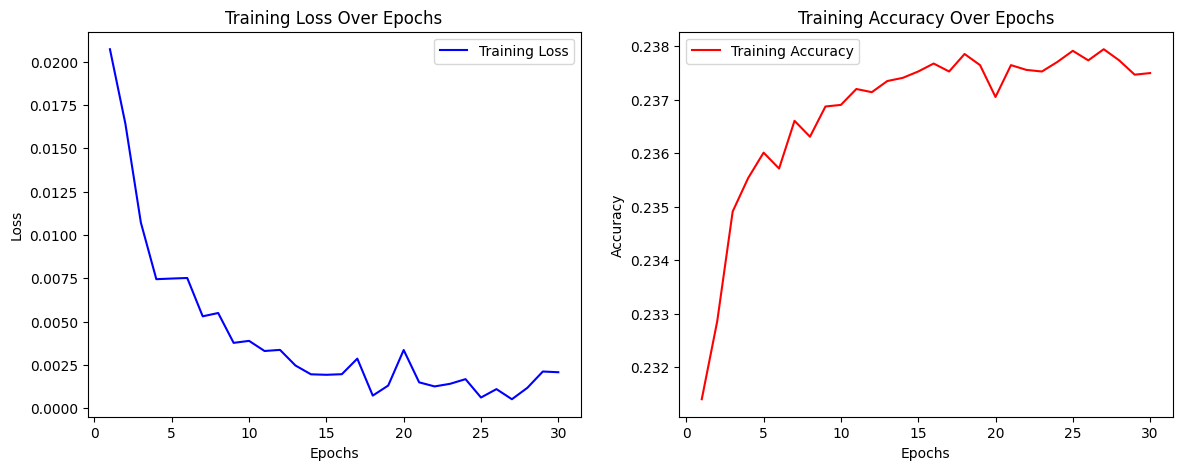

In [22]:
# train_losses and train_accuracies that store loss and accuracy after each epoch
def plot_training_progress(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot the training loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# After training, visualize the progress
plot_training_progress(train_losses, train_accuracies)

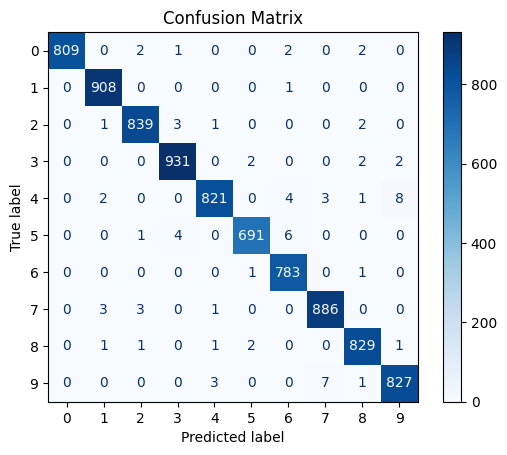

In [23]:
# Get confusion metrics to see module performing
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Save my trained model
model_path = '/content/drive/MyDrive/Data/digit/mymodel.pkl'
torch.save(model, model_path)

In [24]:
# Save prediction
# Step 1 - Load my test data
test_data_path = '/content/drive/MyDrive/Data/digit/test.csv'
test_df = pd.read_csv(test_data_path)

In [37]:
# Step 2 - Prepare the test data

# Convert DataFrame to NumPy array
test_array = test_df.values.astype('float32')

# Convert the NumPy array to a PyTorch tensor
test_tensor = torch.tensor(test_array)

# Reshape the data
test_tensor = test_tensor.view(-1, 1, 28, 28)

# Define the transformation
transform = transforms.Compose([
    transforms.Normalize((0.1307,), (0.3081,))  # Example normalization, adjust based on the dataset
])

# Apply transformation to the reshaped tensor
test_tensor = transform(test_tensor)

# Create a DataLoader for the test data (batch processing)
batch_size = 64
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [38]:
# Step 3
# Load the trained model
model_path = '/content/drive/MyDrive/Data/digit/mymodel.pkl'
model = torch.load(model_path)
model.eval()

# Make predictions on the full test dataset
all_predictions = []

with torch.no_grad():
     for data in test_loader:
        inputs = data[0]  # Get the inputs from the dataloader
        outputs = model(inputs)
        predicted_classes = torch.argmax(outputs, dim=1)
        all_predictions.extend(predicted_classes.cpu().numpy())  # Convert to numpy and store


# Process and save the predictions
predictions_df = pd.DataFrame({
    'ImageID': range(1, len(all_predictions) + 1),  # Auto-increment ImageID
    'Label': all_predictions
})

# Save the prediction to a CSV file
predictions_df.to_csv('/content/drive/MyDrive/Data/digit/prediction.csv', index=False)

print(f"Number of predictions: {len(all_predictions)}")

Number of predictions: 28000
